In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import numpy as np 
import matplotlib.pyplot as plt 

In [6]:
(x_train, y_train),(x_test, y_test) = datasets.mnist.load_data() 

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


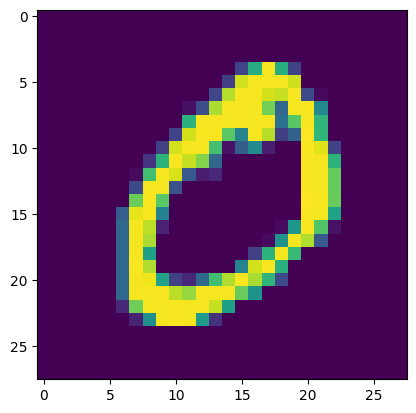

In [10]:
plt.imshow(x_train[1])

In [15]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [16]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [17]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

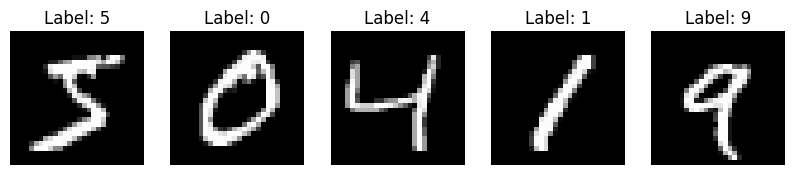

In [20]:
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1, 5 , i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.title(f'Label: {np.argmax(y_train[i])}')
    plt.axis("OFF")
    
plt.show()

In [ ]:
model = models.Sequential([
    # layer One
	layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    
    #layer two
    layers.Conv2D(62, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2))
    
])

In [23]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)